Run batch file to download Greenland Ice Sheet solid ice discharge data from [Mankoff and others (2020)](https://doi.org/10.22008/promice/data/ice_discharge/d/v02)

In [ ]:
!cd ../data/discharge/ & discharge_download.bat

Load and subset data to glaciers and parameters of interest

In [1]:
import geopandas as gpd
import xarray as xr

# Get glacier basin names from centreline attribute table
glaciers = gpd.read_file("../data/misc/centreline_lines.geojson").glacier.unique()

# Load discharge data and subset by glaciers
discharge_ds = xr.open_dataset("../data/discharge/discharge_gate.nc", engine="h5netcdf").load()
discharge_ds = discharge_ds.where(discharge_ds.name_Mouginot.isin(glaciers), drop=True)

# Restructure dimensions and coordinates and drop unnecessary variables
discharge_ds = discharge_ds.assign_coords(x=discharge_ds.mean_x, y=discharge_ds.mean_y, glacier=("gate", glaciers))
discharge_ds = discharge_ds.swap_dims(dict(gate="glacier"))
discharge_ds = discharge_ds[["discharge", "err", "coverage"]]

# Write to disk
discharge_ds.to_netcdf("../data/discharge/discharge_monthly_1986_2024.nc")
discharge_ds

<xarray.Dataset> Size: 92kB
Dimensions:    (glacier: 2, time: 2863)
Coordinates:
  * time       (time) datetime64[ns] 23kB 1986-04-15 1986-05-15 ... 2024-04-15
    gate       (glacier) int64 16B 136 207
    x          (glacier) float64 16B 5.551e+05 4.863e+05
    y          (glacier) float64 16B -1.899e+06 -2.425e+06
  * glacier    (glacier) object 16B 'DAUGAARD-JENSEN' 'UNNAMED_UUNARTIT_ISLANDS'
Data variables:
    discharge  (glacier, time) float32 23kB 9.456 9.439 9.831 ... 4.519 4.397
    err        (glacier, time) float32 23kB 0.615 0.6146 ... 0.4196 0.4085
    coverage   (glacier, time) float32 23kB 0.0 0.9748 1.0 ... 0.6457 0.7885
Attributes:
    featureType:      timeSeries
    title:            Greenland discharge
    summary:          Greenland discharge per gate
    keywords:         Greenland; Ice Discharge; Calving; Submarine Melt
    source:           git commit: 0990889
    creator_name:     Ken Mankoff
    creator_email:    kdm@geus.dk
    creator_url:      http://kenmankoff.com
    institution:      GEUS
    references:       10.22008/promice/ice_discharge
    product_version:  2.0

Quick visualisation of solid ice discharge time series

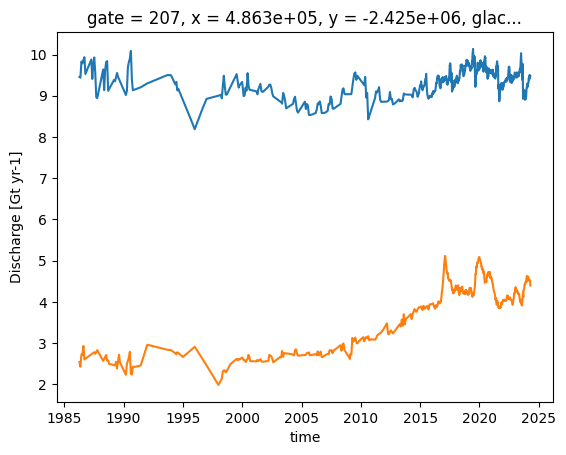

In [2]:
for _, ds in discharge_ds.groupby("glacier", squeeze=False):
    ds.discharge.plot()

Linear regression of annual discharge against time

In [85]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

# Load discharge data
discharge_ds = xr.open_dataset("../data/discharge/discharge_monthly_1986_2024.nc")

for i, (glacier, ds) in enumerate(discharge_ds.groupby("glacier", squeeze=False)):
    # Filter discharge by coverage, resample to annual means, and filter again by annual sample count
    discharge_count = ds.discharge.resample(time="1YS").count()
    discharge = ds.discharge.where(ds.coverage >= 0.50).squeeze()
    discharge = discharge.resample(time="1YS").mean()
    discharge = discharge.where(discharge_count >= 3).squeeze()

    # Extract years from filtered data
    years = discharge.time.dt.year

    # Mask null values
    mask = discharge.notnull() & years.notnull()
    discharge = discharge.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress discharge against year
    res = scipy.stats.linregress(years, discharge)

    # Plot data and trendline
    axs[i].plot(years, discharge, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
            loc="lower right",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)
    axs[i].set_xlabel("Year")

axs[0].set_ylabel("Solid ice discharge [Gt a${-1}$]", size=14)

plt.show()

Solid ice discharge time series

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from matplotlib.dates import DateFormatter, YearLocator
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Global plot settings
PLOT_SETTINGS = {
    "DAUGAARD-JENSEN": {
        "colour": [(0.122, 0.467, 0.706, 1.0), (0.122, 0.467, 0.706, 0.25)],
        "label": "Daugaard-Jensen",
    },
    "UNNAMED_UUNARTIT_ISLANDS": {
        "colour": [(1.0, 0.498, 0.055, 1.0), (1.0, 0.498, 0.055, 0.25)],
        "label": "Uunartit Islands",
    },
}

# Global plot settings
plt.rcParams["figure.dpi"] = 1000
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

# Set up axes
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0, 0])

# Load discharge data
discharge_ds = xr.open_dataset("../data/discharge/discharge_monthly_1986_2024.nc")

for glacier, ds in discharge_ds.groupby("glacier", squeeze=False):
    ds = ds.where(ds.coverage >= 0.50).squeeze()

    ax.errorbar(
        ds.discharge.time.values,
        ds.discharge.values,
        ds.err.values,
        marker="o",
        linestyle="-",
        markersize=3,
        linewidth=2.5,
        elinewidth=0.75,
        markeredgecolor=PLOT_SETTINGS[glacier]["colour"][0],
        markerfacecolor=PLOT_SETTINGS[glacier]["colour"][0],
        color=PLOT_SETTINGS[glacier]["colour"][1],
        ecolor=PLOT_SETTINGS[glacier]["colour"][1],
        label=PLOT_SETTINGS[glacier]["label"],
    )

    # discharge_annual = ds.discharge.resample(time="1YS").mean().squeeze()
    # for da in discharge_annual:
    #     ax.hlines(
    #         y=da.values,
    #         xmin=da.time.values,
    #         xmax=da.time.values + np.timedelta64(365, "D"),
    #         colors="#219ebc",
    #         linestyles="--",
    #         linewidth=1.5,
    #         zorder=1,
    #     )

# Set y-axis range to fit data and adds label
ax.set_ylim(bottom=0, top=12)
ax.set_ylabel("Solid ice discharge [Gt a$^{-1}$]", labelpad=20)

# Set x-axis range to fit data
ax.set_xlim(pd.to_datetime("1985-01-01"), pd.to_datetime("2024-01-01"))

# Format x-axis ticks: text format, frequency, rotation
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_major_locator(YearLocator(5))
ax.xaxis.set_minor_locator(YearLocator(1))
ax.tick_params(axis="x", rotation=70)

# Remove margin gap
ax.margins(x=0)

# Draw: horizontal line at y=0, grid, axes label
ax.axhline(y=0, c="black", alpha=0.7, linewidth=0.7, zorder=1, linestyle=(0, (6, 8)))
ax.grid(True, which="both", axis="both", c="gray", linestyle=":", linewidth=0.5, alpha=0.8, zorder=0)
ax.add_artist(AnchoredText("(x)", loc="upper left", borderpad=0.1, prop=dict(weight="semibold"), frameon=False))

plt.tight_layout()
plt.savefig("../img/ts_discharge.png", dpi=fig.dpi, bbox_inches="tight")
plt.show()